In [1]:
from more_memory_efficient.modeling_llama_offload_attention import LlamaForCausalLM as LlamaForCausalLM_Offload
from more_memory_efficient.cache import CPUCache
from transformers import LlamaForCausalLM, AutoConfig
from tqdm import tqdm
import torch
import time

In [2]:
model_offload = LlamaForCausalLM_Offload.from_pretrained(
    'mesolitica/malaysian-tinyllama-1.1b-16k-instructions-v4',
                                        torch_dtype = torch.bfloat16).cuda()

In [3]:
input_ids = torch.tensor([5] * 30000).unsqueeze(0).cuda()

In [4]:
cache = CPUCache()

In [5]:
memory_allocated, time_taken = [], []
with torch.no_grad():
    with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_mem_efficient=False, enable_math=True):
        for i in tqdm(range(1000)):
            logits = model_offload.forward(input_ids, past_key_values = cache, use_cache = True).logits
            input_ids = logits.argmax(-1)[:, -1:]
            del logits
            memory_allocated.append(torch.cuda.memory_allocated())
            time_taken.append(time.time())

/home/husein/.local/lib/python3.10/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [24:03<00:00,  1.44s/it]


In [6]:
import json

with open('llama-1.1b-offload-group5-30k.json', 'w') as fopen:
    json.dump({
        'memory_allocated': memory_allocated,
        'time_taken': time_taken,
    }, fopen)

In [8]:
# from llama-1.1b-30k.ipynb

with open('llama-1.1b-30k.json') as fopen:
    full = json.load(fopen)

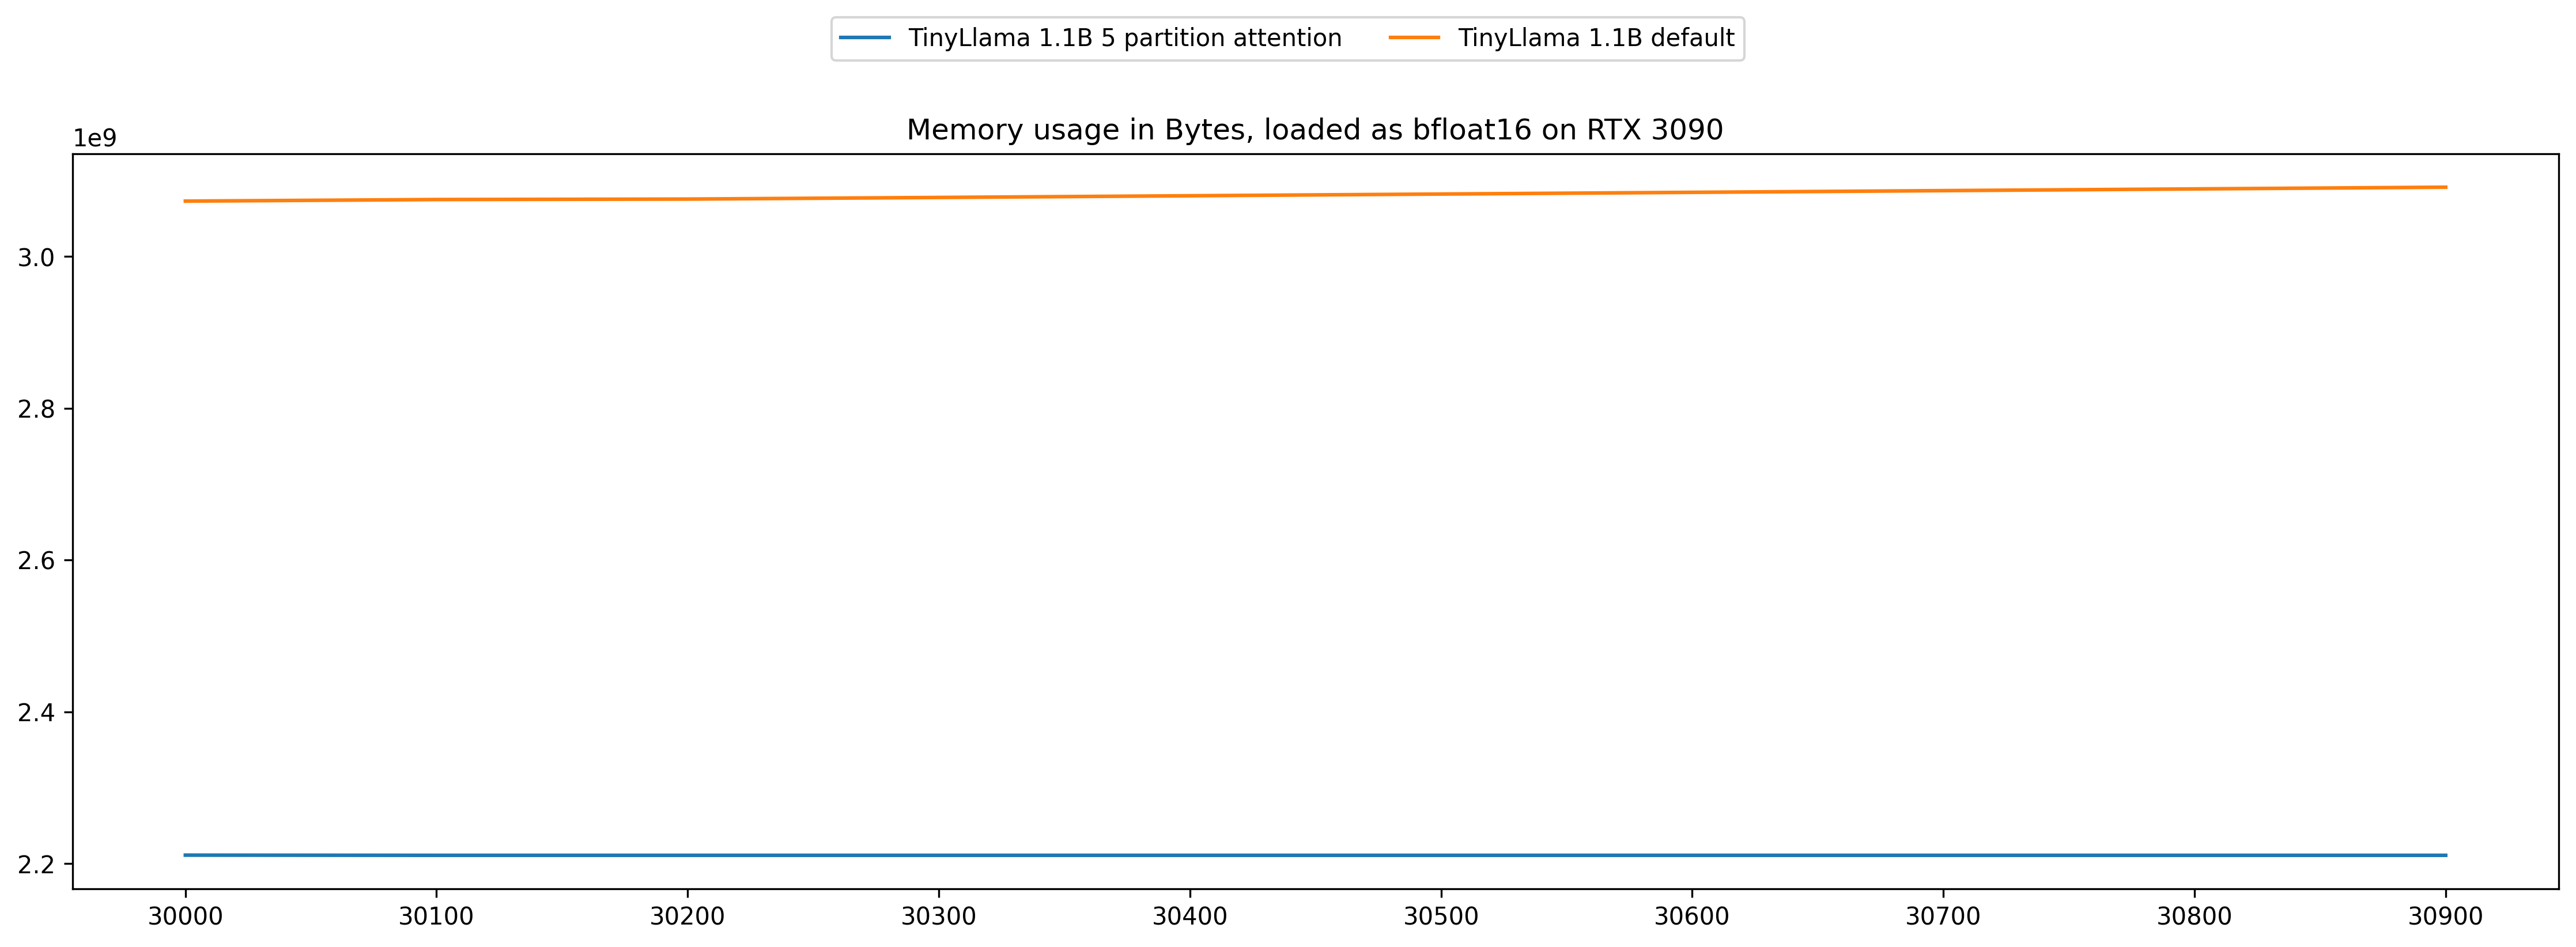

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5), dpi = 300)
ax1.plot(memory_allocated[::100], label = 'TinyLlama 1.1B 5 partition attention')
ax1.plot(full['memory_allocated'][::100], label = 'TinyLlama 1.1B default')
ax1.set_xticks(np.arange(10))
ax1.set_xticklabels(np.arange(30000, 31000, 100))
handles, labels = ax1.get_legend_handles_labels()
ax1.set_title('Memory usage in Bytes, loaded as bfloat16 on RTX 3090')
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

fig.tight_layout()
plt.show()